In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [3]:
# Create a simple dataset for classification
class ClassificationDataset(Dataset):
    def __init__(self, num_samples=1000, num_classes=3):
        self.X = torch.randn(num_samples, 5)
        # Create a non-linear decision boundary
        self.y = (torch.sin(self.X[:, 0]) + torch.exp(self.X[:, 1] / 2) + self.X[:, 2]**2 - self.X[:, 3] + self.X[:, 4]).long() % num_classes

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


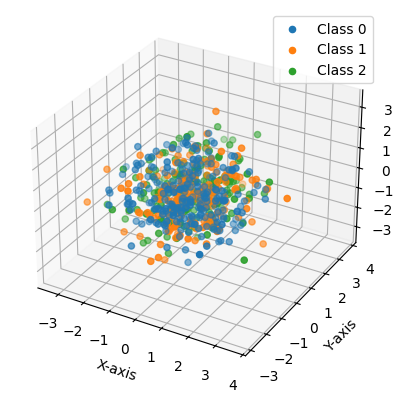

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming the dataset is 3D for visualization purposes
def plot_classification_dataset(dataset):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, y = dataset.X, dataset.y
    for label in np.unique(y):
        ax.scatter(X[y==label, 0], X[y==label, 1], X[y==label, 2], label=f'Class {label}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    plt.legend()
    plt.show()

# Example usage
plot_classification_dataset(train_dataset)


In [36]:
# Define the neural network for classification
class ClassificationNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        return self.layers(x)


In [42]:
def test_accuracy(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item() * len(batch_X)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(batch_y.numpy())
    
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(true_labels, predictions)
    return avg_loss, accuracy, classification_report(true_labels, predictions), confusion_matrix(true_labels, predictions)

In [43]:
# Create datasets and dataloaders
train_dataset = ClassificationDataset(num_samples=600)
val_dataset = ClassificationDataset(num_samples=200)
test_dataset = ClassificationDataset(num_samples=200)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
# Initialize the model, loss function, and optimizer
model = ClassificationNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Training loop
num_epochs = 200
best_val_accuracy = 0

# Loop for the specified number of epochs
for epoch in range(num_epochs):
    # Set the model to training mode
    # This is important for layers like Dropout and BatchNorm which behave differently during training
    model.train()
    
    # Iterate over batches of data from the training loader
    for batch_X, batch_y in train_loader:
        # Zero out the gradients from the previous batch
        # This is necessary because PyTorch accumulates gradients
        optimizer.zero_grad()
        
        # Forward pass: compute the model output for this batch
        outputs = model(batch_X)
        
        # Compute the loss between the model outputs and true labels
        loss = criterion(outputs, batch_y)
        
        # Backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()
        
        # Update the model parameters using the computed gradients
        optimizer.step()
    
    # Validate the model
    val_loss, val_accuracy, _, _ = test_accuracy(model, val_loader, criterion)
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_classification_model.pth')

/Users/ducdo/Repo/Coding-Interview/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ducdo/Repo/Coding-Interview/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ducdo/Repo/Coding-Interview/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Epoch [20/200], Train Loss: 1.1430, Val Loss: 1.0328, Val Accuracy: 0.4800
Epoch [40/200], Train Loss: 0.7490, Val Loss: 0.9888, Val Accuracy: 0.5100
Epoch [60/200], Train Loss: 0.6027, Val Loss: 0.9863, Val Accuracy: 0.5150
Epoch [80/200], Train Loss: 0.5942, Val Loss: 0.9756, Val Accuracy: 0.5350
Epoch [100/200], Train Loss: 0.3315, Val Loss: 1.0366, Val Accuracy: 0.5650
Epoch [120/200], Train Loss: 0.2910, Val Loss: 1.0916, Val Accuracy: 0.5950
Epoch [140/200], Train Loss: 0.3880, Val Loss: 1.1069, Val Accuracy: 0.6050
Epoch [160/200], Train Loss: 0.2649, Val Loss: 1.2136, Val Accuracy: 0.5950
Epoch [180/200], Train Loss: 0.1480, Val Loss: 1.2769, Val Accuracy: 0.6200
Epoch [200/200], Train Loss: 0.2519, Val Loss: 1.3559, Val Accuracy: 0.6100


In [31]:
# Load the best model
model.load_state_dict(torch.load('best_classification_model.pth'))

# Test the model
test_loss, test_accuracy, test_report, test_cm = test_accuracy(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
print("Classification Report:")
print(test_report)
print("Confusion Matrix:")
print(test_cm)


Test Loss: 1.4535, Test Accuracy: 0.6250
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        89
           1       0.57      0.57      0.57        53
           2       0.52      0.55      0.53        58

    accuracy                           0.62       200
   macro avg       0.61      0.61      0.61       200
weighted avg       0.63      0.62      0.63       200

Confusion Matrix:
[[63  9 17]
 [10 30 13]
 [12 14 32]]


In [32]:
# Evaluate on a separate evaluation dataset
model.load_state_dict(torch.load('best_classification_model.pth'))
eval_dataset = ClassificationDataset(num_samples=500)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)
eval_loss, eval_accuracy, eval_report, eval_cm = test_accuracy(model, eval_loader, criterion)
print(f'Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}')

TypeError: 'float' object is not callable

In [33]:
# Make predictions on new data
new_data = torch.randn(7, 5)  # 7 samples with 5 features each
model.eval()
with torch.no_grad():
    outputs = model(new_data)
    _, predictions = torch.max(outputs, 1)
print("Predictions for new data:")
print(predictions)

Predictions for new data:
tensor([2, 1, 0, 2, 2, 2, 1])
